# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.509971,True,5.106935
1,-2.279580,False,-7.656264
2,0.090178,False,1.634287
3,-1.485591,False,-3.003357
4,-1.515771,False,-4.279850
...,...,...,...
995,-0.505698,False,-2.306869
996,-1.851319,False,-5.556046
997,-0.357219,True,4.697552
998,0.093507,True,5.261350


<AxesSubplot:xlabel='v0'>

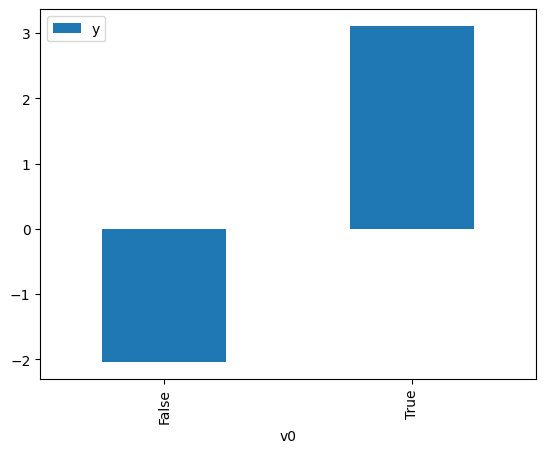

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

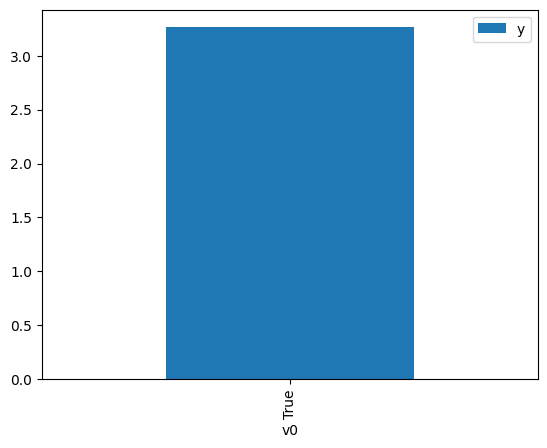

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-3.811132,False,-11.072421,0.963026,1.038393
1,-0.721071,False,-2.101885,0.663798,1.506482
2,1.831690,False,4.609552,0.189879,5.266514
3,-1.680660,False,-5.502894,0.814775,1.227333
4,-1.769194,False,-6.048841,0.825670,1.211137
...,...,...,...,...,...
995,-1.074855,False,-4.944021,0.726236,1.376963
996,-2.105776,False,-5.790628,0.862502,1.159417
997,0.631043,False,1.953076,0.389720,2.565942
998,-2.270395,False,-8.282369,0.878003,1.138948


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.441962,True,4.224387,0.390011,2.564029
1,-1.254880,True,1.870187,0.244919,4.082975
2,-0.761666,True,3.070755,0.328681,3.042463
3,-2.258257,True,-2.094508,0.123086,8.124375
4,-1.565701,True,0.777448,0.200148,4.996308
...,...,...,...,...,...
995,-1.195692,True,0.271072,0.254172,3.934347
996,0.502046,True,6.946538,0.584385,1.711201
997,-2.052953,True,-1.339868,0.142812,7.002236
998,-1.348410,True,1.496327,0.230769,4.333340


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              8741.
Date:                Fri, 02 Sep 2022   Prob (F-statistic):                        0.00
Time:                        10:27:48   Log-Likelihood:                         -1430.2
No. Observations:                1000   AIC:                                      2864.
Df Residuals:                     998   BIC:                                      2874.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8690      0.027    105.914      0.000       2.816       2.922
x2             5.0125      0.054     92.704      0.000       4.906       5.119
==============================================================================
Omnibus:                        0.964   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                0.832
Skew:                          -0.040   Prob(JB):                        0.660
Kurtosis:                       3.117   Cond. No.                         2.03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""